55.0787 144.3149 66.3622 177.3616


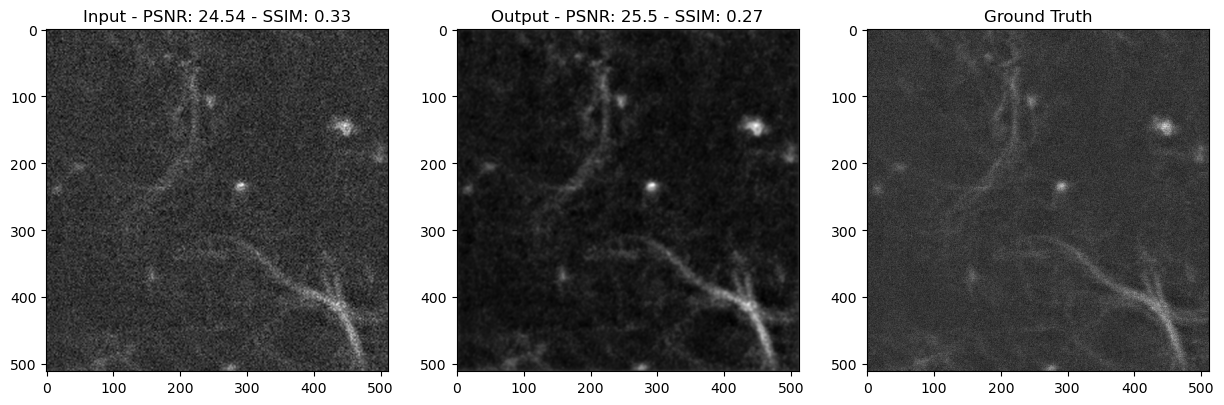

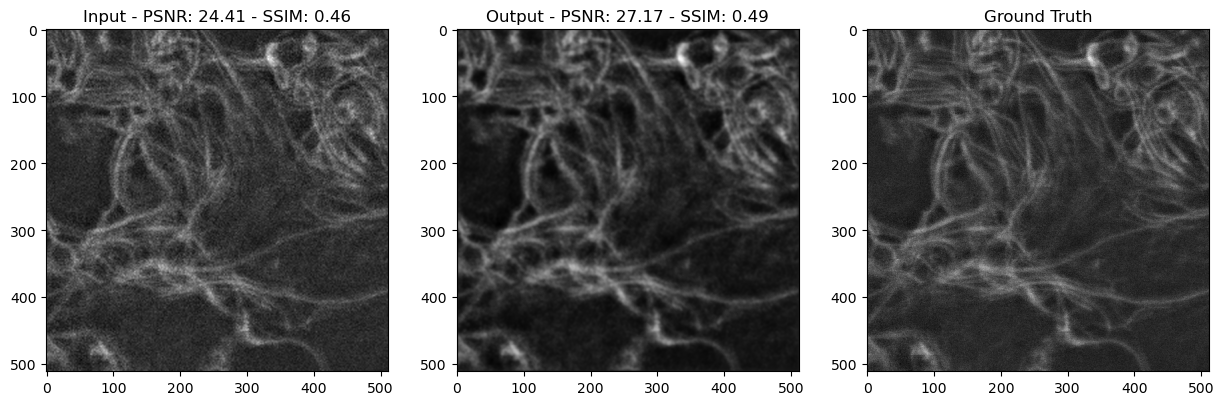

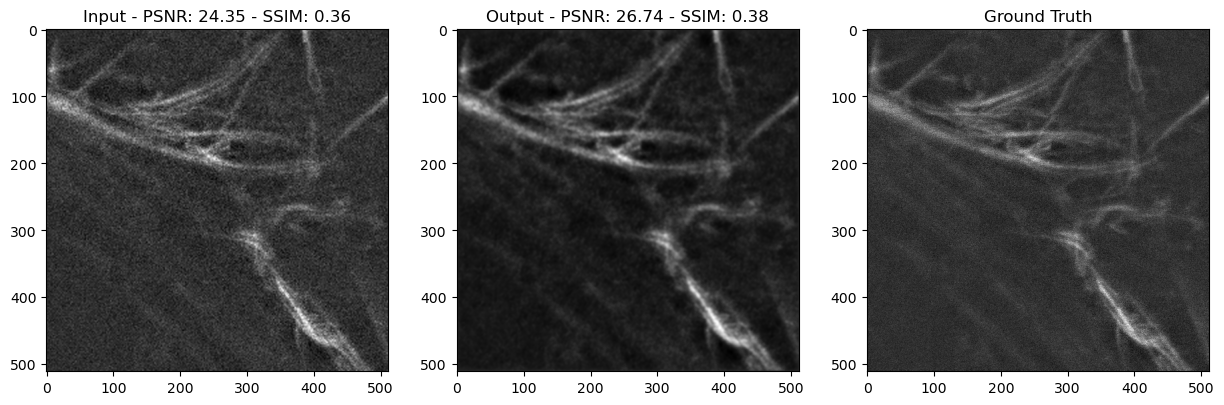

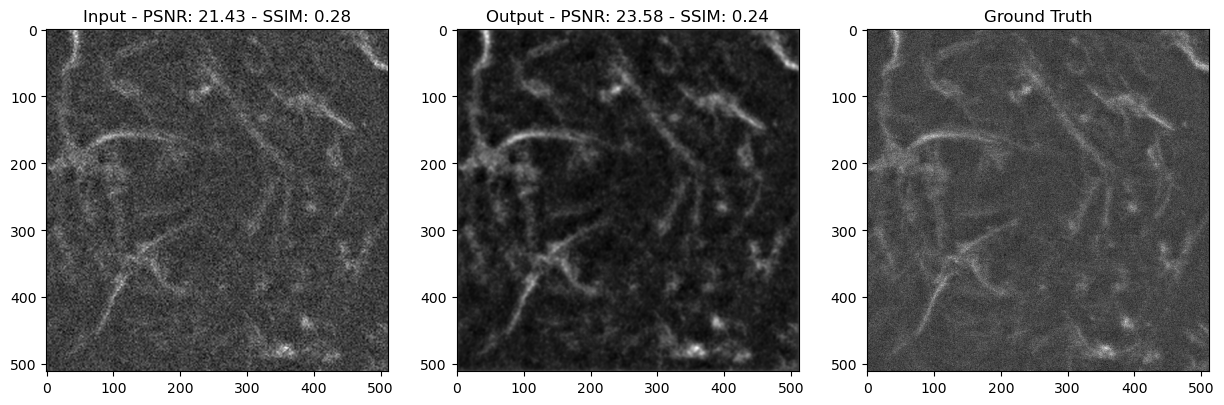

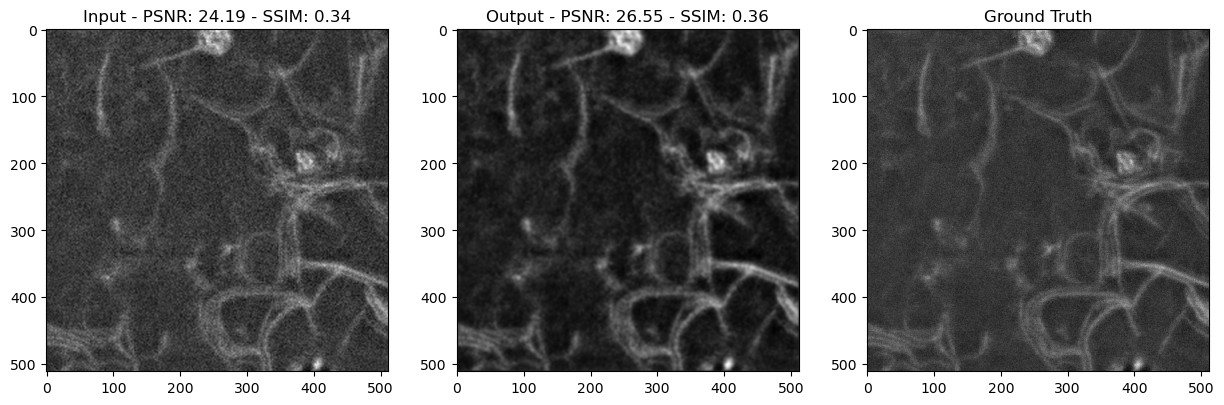

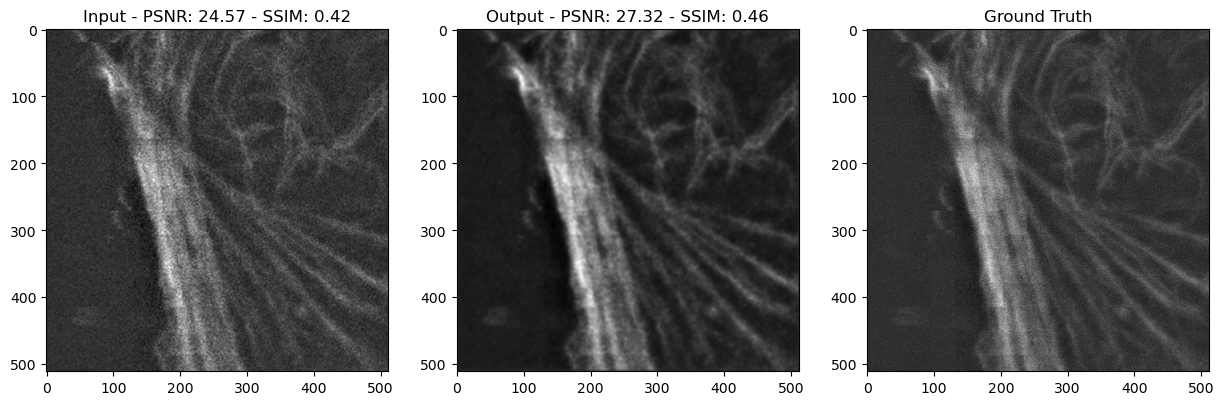

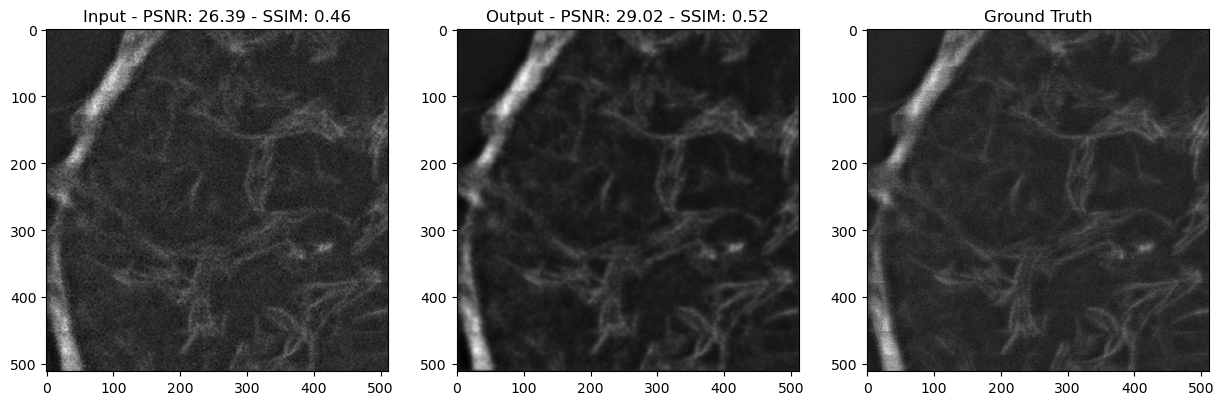

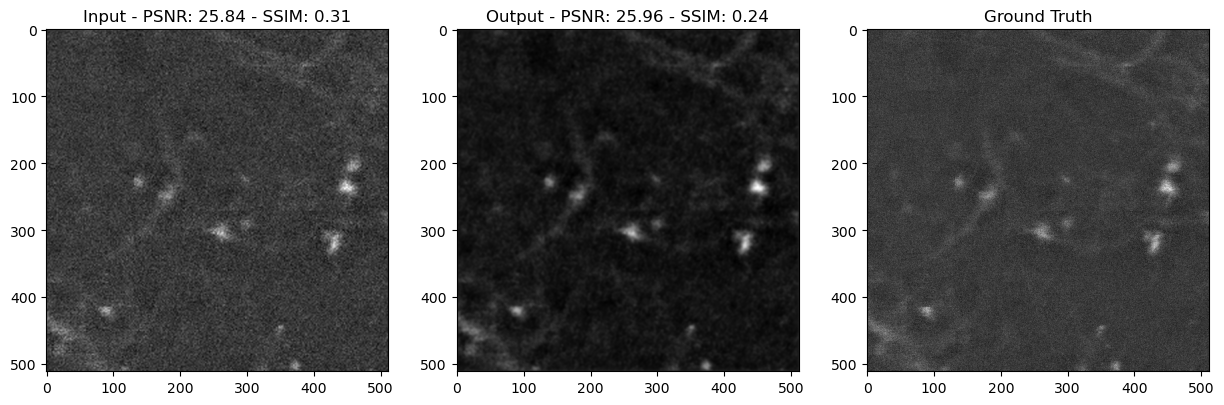

In [16]:
#import libraries
import torch
import os
from pathlib import Path
import imageio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from Models import UNet
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import torchvision
from tifffile import imsave
from Data import SimpleMonalisaDataset
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import math as m

avg_input = 55.0787
std_input = 144.3149
avg_gt = 66.3622
std_gt = 177.3616


input_dir_test = "/mnt/efs/shared_data/restorators/monalisa_data/Actin_20nmScanStep/train/input"
gt_dir_test = "/mnt/efs/shared_data/restorators/monalisa_data/Actin_20nmScanStep/train/gt"

transform = transforms.CenterCrop(512)

test_data = SimpleMonalisaDataset(input_dir_test,gt_dir_test, transform=transform, mean_input = avg_input, std_input = std_input, mean_gt = avg_gt, std_gt = std_gt)
test_loader = DataLoader(test_data,batch_size=5)

model = torch.load("/home/guillaumem/the_restorators/model_L1_depth2.pt")
device = torch.device ("cuda")

for idx, (input, gt) in enumerate(test_loader):
    
    input = input.to(device)
    prediction = model(input)
    
    
    input = input.cpu().numpy()
    gt = gt.cpu().numpy()
    prediction = prediction.cpu().detach().numpy()

    input =input[0,0,...]
    gt = gt[0,0,...]
    prediction = prediction [0,0,...]

    range = np.max(gt) - np.min(gt)

    psnr_input = round(psnr(gt,input,data_range=range),2)
    ssim_input = round(ssim(gt,input,data_range=range),2)    

    psnr_test = round(psnr(gt,prediction,data_range=range),2)
    ssim_test = round(ssim(gt,prediction,data_range=range),2)
    
    #imsave(f"inference_results/pred{idx:02d}.tiff",prediction)
    #imsave(f"inference_results/gt{idx:02d}.tiff",gt)
    #imsave(f"inference_results/input{idx:02d}.tiff",input)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1,3,1)
    plt.title(f"Input - PSNR: {psnr_input} - SSIM: {ssim_input}")
    plt.imshow(input,cmap='gray')
    plt.subplot(1,3,2)
    plt.title(f"Output - PSNR: {psnr_test} - SSIM: {ssim_test}")
    plt.imshow(prediction,cmap='gray')
    plt.subplot(1,3,3)
    plt.title("Ground Truth")
    plt.imshow(gt,cmap='gray')
    plt.show()

